# Przerwy energetyczne na podłożu GaSb z naprężeniami:

Materiał: GaAlSb  
Podłoże: GaSb

#### Imports:

In [2]:
import os, re
import numpy as np
from mendeleev import element
from collections import Counter
import importlib
import matplotlib.pyplot as plt

from src.material_analysis import material_type_checker, binary_compounds_decomposition 
from src.utils import roman_to_int
from src.data_utils import read_binary_compounds_all_band_gaps, read_alloys_param, read_binary_compounds_param

### Load material:

In [3]:
#material = 'GaAlGeSb'
material = 'AlGaSb'
ground_material = 'GaSb'

component_names = re.findall('[A-Z][^A-Z]*', material) 
print("Components: ", component_names)

material_type, material_type_extensive = material_type_checker(material)
print("Material type:", material_type)
print("Material type extensive:", material_type_extensive)

compounds = binary_compounds_decomposition(material)
print("Binary compounds: ", compounds)

Components:  ['Al', 'Ga', 'Sb']
Material type: IIIA_VA
Material type extensive: IIIA_2_VA_1
Binary compounds:  ['AlSb', 'GaSb']


## Energy band characteristics - no tensions:

### Band gaps in temperature of `300K` from mole fraction:

Import simulation module:

In [4]:
try:
    libname = ".".join(["src", "simulations", material_type])
    simulation = importlib.import_module(libname)
    simulation = importlib.reload(simulation)
except ImportError:
    simulation = None
    print(f'Simulation method for \'{material_type}\' not implemented.')
else:
    globals()[libname] = simulation

Read band gaps in `T=0K`:

In [5]:
params_file_path = os.path.join(".", "materials", "binary_compounds")

points_names = ['gamma', 'x', 'l']
egs_0k, alphas, betas = read_binary_compounds_all_band_gaps(compounds, params_file_path, points_names)
egs_0k, alphas, betas

(array([[2.386, 1.696, 2.329],
        [0.812, 1.141, 0.875]]),
 array([[0.00042 , 0.00039 , 0.00058 ],
        [0.000417, 0.000475, 0.000597]]),
 array([[140., 140., 140.],
        [140.,  94., 140.]]))

Calculate the band gaps in `T=300K`:

In [6]:
egs_300k = []
for i, c in enumerate(compounds):
    c_egs_300k = []
    for eg, a, b in zip(egs_0k[i], alphas[i], betas[i]):
        c_egs_300k.append(simulation.calculating_bandgaps_from_varshni_relation(eg, a, b, t=300))
    egs_300k.append(c_egs_300k)

egs_300k = np.array(egs_300k)
egs_300k

array([[2.30009091, 1.61622727, 2.21036364],
       [0.72670455, 1.03249746, 0.75288636]])

Calculate bandgap from mole fractions (no strains):

In [7]:
params_file_path = os.path.join(".", "materials", "ternary_alloys")

bowing_parameters = []
for point in points_names:
    bowing_parameters.append(read_alloys_param(material, params_file_path, f'C_Eg_{point}'))

Eg_x = []
x = []
for i, point in enumerate(points_names):
    calc_params = {"bowing_parameters": bowing_parameters[i]}
    x, point_Eg_x = simulation.band_gap_from_mole_fraction(egs_300k[:,i], 
                                                           material_type_extensive, 
                                                           calc_params=calc_params, 
                                                           method="VCA", 
                                                           points=20)
    Eg_x.append(point_Eg_x)

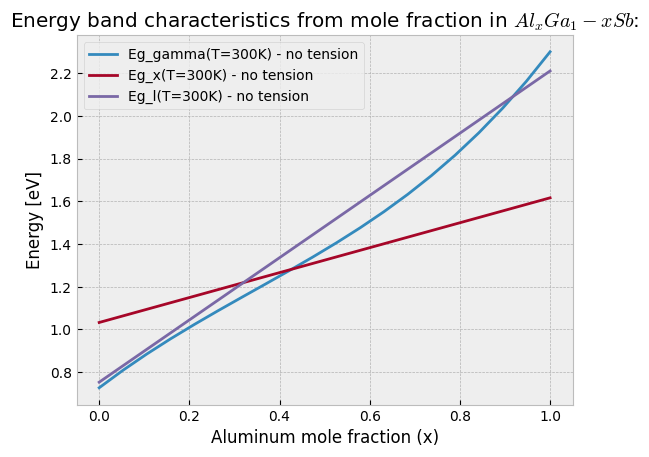

In [8]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(1,1)
    for i, point in enumerate(points_names):
        ax.plot(x, Eg_x[i], '-', label=f'Eg_{point}(T=300K) - no tension')
    
    ax.set_title(r'Energy band characteristics from mole fraction in ${}_x{}_{a}{}$:'.format(*component_names, a="1-x"))
    ax.set_ylabel("Energy [eV]")
    ax.set_xlabel(f'{element(component_names[0]).name} mole fraction (x)')
    
    plt.legend()
    plt.show()

## Calculate bandgap from mole fractions (with strains):

In [9]:
params_file_path = os.path.join(".", "materials", "binary_compounds")

VBO_comps = read_binary_compounds_param(compounds, params_file_path, "VBO")

In [10]:
calc_params = {"bowing_parameters": 0.}
x, VBO = simulation.band_gap_from_mole_fraction(VBO_comps, 
                                                  material_type_extensive, 
                                                  calc_params=calc_params, 
                                                  method="VCA", 
                                                  points=20)

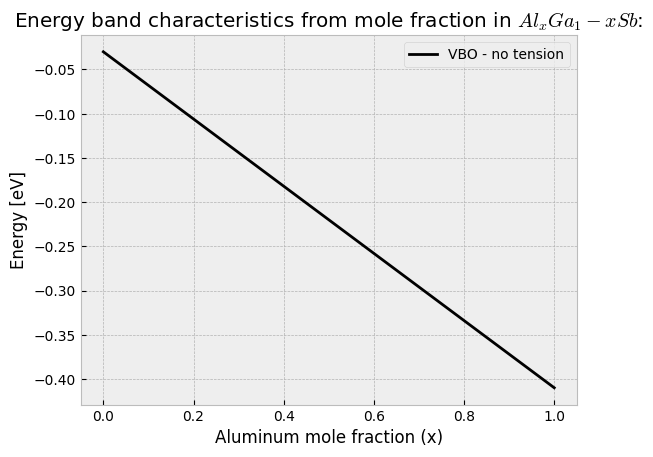

In [11]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(1,1)
    
    ax.plot(x, VBO, '-', color='black', label=f'VBO - no tension')
    
    ax.set_title(r'Energy band characteristics from mole fraction in ${}_x{}_{a}{}$:'.format(*component_names, a="1-x"))
    ax.set_ylabel("Energy [eV]")
    ax.set_xlabel(f'{element(component_names[0]).name} mole fraction (x)')
    
    plt.legend()
    plt.show()

In [12]:
Ec_x = [point_Eg_x+VBO for point_Eg_x in Eg_x]

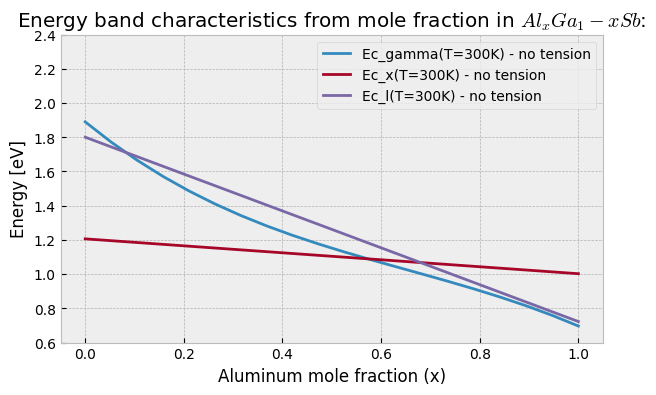

In [13]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(1,1, figsize=(7,4))
    
    for i, point in enumerate(points_names):
        ax.plot(x[::-1], Ec_x[i], '-', label=f'Ec_{point}(T=300K) - no tension')
        
    ax.set_title(r'Energy band characteristics from mole fraction in ${}_x{}_{a}{}$:'.format(*component_names, a="1-x"))
    ax.set_ylabel("Energy [eV]")
    ax.set_xlabel(f'{element(component_names[0]).name} mole fraction (x)')
    ax.set_ylim(0.6, 2.4)
    
    plt.legend()
    plt.show()

## Energy band characteristics - with tensions:

To calculate:
* Ehh i Elh - wierzchołki pasm dziur cięzkich i lekkich z naprężeniami
* z większej liczby wyznaczyć VBO z parężeniami
* Ec - wierzchołek pasma przewodnictwa z naprężeniami - dodać człon z naprężeniami
* Eg - przerwa energetyczna - Ec-VBO z naprężeniami

In [14]:
# read lattice constant coefficient of the components and calculate for room temperature
params_file_path = os.path.join(".", "materials", "binary_compounds")
t = 300

a_0_comps_coeffs = read_binary_compounds_param(compounds, params_file_path, "a_lc")
a_0_comps_300K = []
for a_0_comp in a_0_comps_coeffs:
    a_0_comps_300K.append(a_0_comp[0]+a_0_comp[1]*(t-300))
    
x, a_0_300K = simulation.calculating_lattice_constant_from_vegard_law(a_0_comps_300K, points=20)

In [15]:
# read lattice constant coefficient of the ground material and calculate for room temperature
a_s_coeffs = read_binary_compounds_param([ground_material], params_file_path, "a_lc")[0]
a_s_300K = a_s_coeffs[0]+a_s_coeffs[1]*(t-300)

In [16]:
# elastic stifness constant
c_11_comps = read_binary_compounds_param(compounds, params_file_path, "c_11")
c_12_comps = read_binary_compounds_param(compounds, params_file_path, "c_12")

In [17]:
x, c_11 = simulation.band_gap_from_mole_fraction(c_11_comps, 
                                              material_type_extensive, 
                                              calc_params=calc_params, 
                                              method="VCA", 
                                              points=20)
x, c_12 = simulation.band_gap_from_mole_fraction(c_12_comps, 
                                              material_type_extensive, 
                                              calc_params=calc_params, 
                                              method="VCA", 
                                              points=20)

In [18]:
e_xx = (a_s_300K-a_0_300K)/a_0_300K
e_zz = -2*(c_12*e_xx)/c_11
Tr_e = 2*e_xx+e_zz

In [19]:
a_v_comps = read_binary_compounds_param(compounds, params_file_path, "a_v")
x, a_v = simulation.band_gap_from_mole_fraction(a_v_comps, 
                                                material_type_extensive, 
                                                calc_params=calc_params, 
                                                method="VCA", 
                                                points=20)

a_c_comps = read_binary_compounds_param(compounds, params_file_path, "a_c")
x, a_c = simulation.band_gap_from_mole_fraction(a_c_comps, 
                                                material_type_extensive, 
                                                calc_params=calc_params, 
                                                method="VCA", 
                                                points=20)

b_comps = read_binary_compounds_param(compounds, params_file_path, "b")
x, b = simulation.band_gap_from_mole_fraction(b_comps, 
                                                material_type_extensive, 
                                                calc_params=calc_params, 
                                                method="VCA", 
                                                points=20)

In [22]:
V_lh_strain = VBO+a_v*Tr_e+b*(e_xx-e_zz)
V_hh_strain = VBO+a_v*Tr_e-b*(e_xx-e_zz)

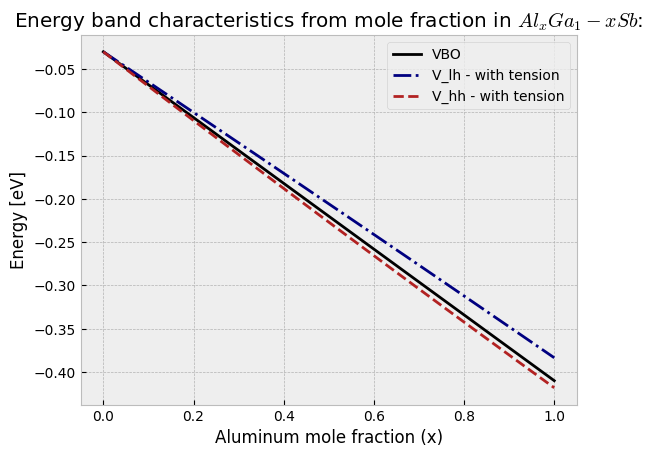

In [30]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(1,1)
    
    ax.plot(x, VBO, '-', color='black', label=f'VBO')
    ax.plot(x, V_lh_strain, '-.', color='navy', label=f'V_lh - with tension')
    ax.plot(x, V_hh_strain, '--', color='firebrick', label=f'V_hh - with tension')
    
    ax.set_title(r'Energy band characteristics from mole fraction in ${}_x{}_{a}{}$:'.format(*component_names, a="1-x"))
    ax.set_ylabel("Energy [eV]")
    ax.set_xlabel(f'{element(component_names[0]).name} mole fraction (x)')
    
    plt.legend()
    plt.show()

In [25]:
Ec_strain = Ec_x+a_c*Tr_e
Eg_strain = Ec_strain-V_lh_strain

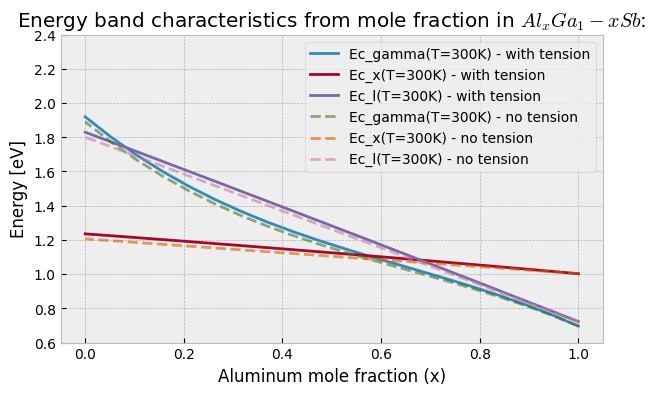

In [35]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(1,1, figsize=(7,4))
    
    for i, point in enumerate(points_names):
        ax.plot(x[::-1], Ec_strain[i], '-', label=f'Ec_{point}(T=300K) - with tension')
    for i, point in enumerate(points_names):
        ax.plot(x[::-1], Ec_x[i], '--', label=f'Ec_{point}(T=300K) - no tension', alpha=0.6)
        
    ax.set_title(r'Energy band characteristics from mole fraction in ${}_x{}_{a}{}$:'.format(*component_names, a="1-x"))
    ax.set_ylabel("Energy [eV]")
    ax.set_xlabel(f'{element(component_names[0]).name} mole fraction (x)')
    ax.set_ylim(0.6, 2.4)
    
    plt.legend()
    plt.show()

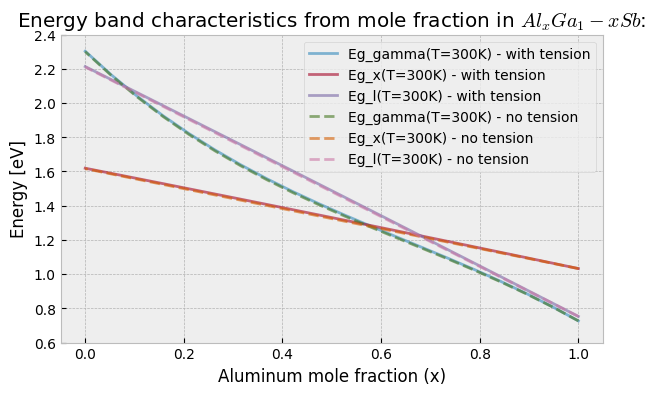

In [39]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(1,1, figsize=(7,4))
    
    for i, point in enumerate(points_names):
        ax.plot(x[::-1], Eg_strain[i], '-', label=f'Eg_{point}(T=300K) - with tension', alpha=0.6)

    for i, point in enumerate(points_names):
        ax.plot(x[::-1], Eg_x[i], '--', label=f'Eg_{point}(T=300K) - no tension', alpha=0.6)
        
    ax.set_title(r'Energy band characteristics from mole fraction in ${}_x{}_{a}{}$:'.format(*component_names, a="1-x"))
    ax.set_ylabel("Energy [eV]")
    ax.set_xlabel(f'{element(component_names[0]).name} mole fraction (x)')
    ax.set_ylim(0.6, 2.4)
    
    plt.legend()
    plt.show()

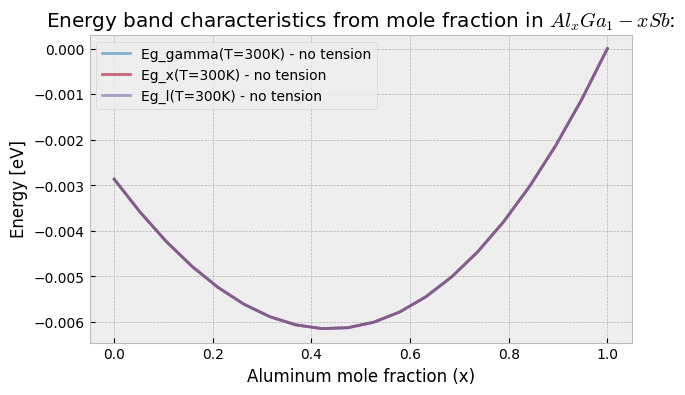

In [41]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(1,1, figsize=(7,4))

    for i, point in enumerate(points_names):
        ax.plot(x[::-1], Eg_x[i]-Eg_strain[i], '-', label=f'Eg_{point}(T=300K) - no tension', alpha=0.6)
        
    ax.set_title(r'Energy band characteristics from mole fraction in ${}_x{}_{a}{}$:'.format(*component_names, a="1-x"))
    ax.set_ylabel("Energy [eV]")
    ax.set_xlabel(f'{element(component_names[0]).name} mole fraction (x)')
    #ax.set_ylim(0.6, 2.4)
    
    plt.legend()
    plt.show()